# 📊 Visualizações e Análises Exploratórias — Camada Gold (Views)

Este notebook tem como objetivo construir **visões analíticas temporárias** com base na **camada Silver**, permitindo análises exploratórias sobre a evolução e o comportamento dos preços de criptoativos.

As visualizações aqui propostas foram pensadas para:
- Ajudar stakeholders a entender tendências de mercado
- Facilitar o monitoramento da volatilidade intradiária
- Comparar o desempenho dos diferentes ativos

⚠️ **Importante**: As views são geradas diretamente no notebook via bibliotecas de visualização, de forma que possam ser exportadas e visualizadas em repositórios como o GitHub.

## 🔧 Tecnologias
- PySpark (leitura da camada Silver)
- Pandas (manipulação leve dos dados)
- Matplotlib / Seaborn / Plotly (gráficos)

---

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
catalogo = "lakehouse"
schema = "silver"
table = "cripto"
full_table_name = f"{catalogo}.{schema}.{table}"

# 📊 1. Evolução do Preço por Ativo ao Longo do Tempo

/root/.ipykernel/1146/command-6057980840509041-62826061:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


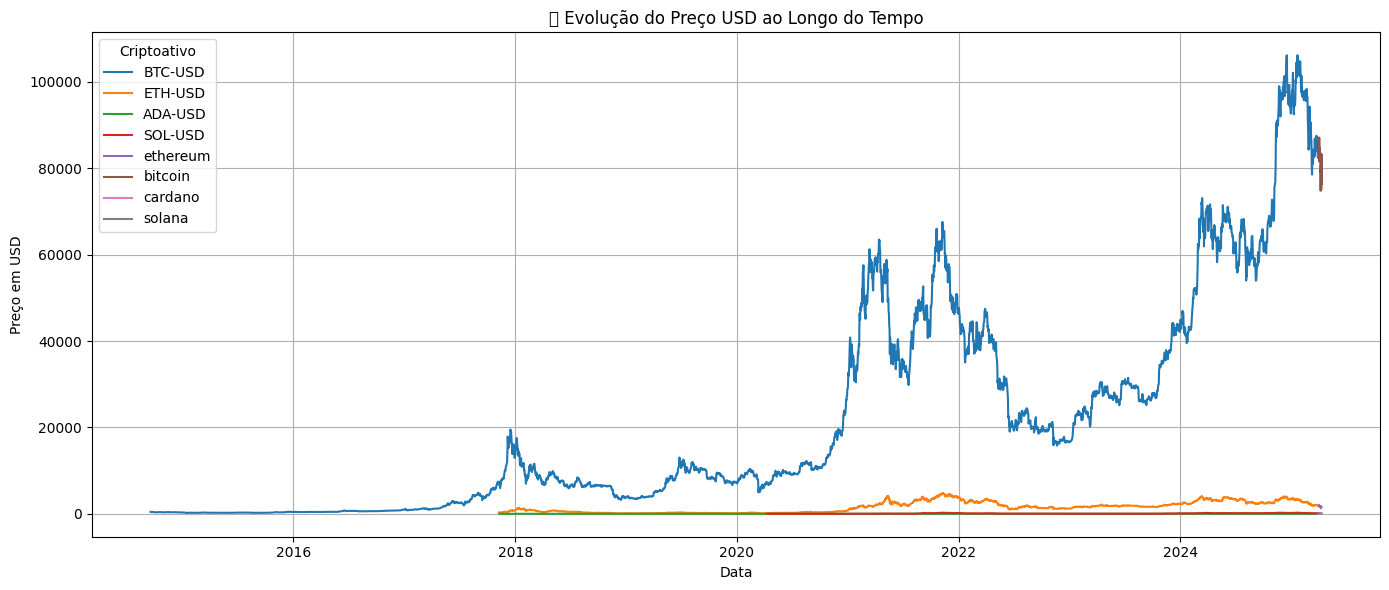

In [0]:
# Leitura dos dados da camada Silver
df_silver = spark.read.table(f"{full_table_name}")
df_price = df_silver.select("timestamp", "asset_name", "price_usd").toPandas()

# Conversão e ordenação
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"])
df_price = df_price.sort_values(by="timestamp")

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_price, x="timestamp", y="price_usd", hue="asset_name")
plt.title("📈 Evolução do Preço USD ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Preço em USD")
plt.legend(title="Criptoativo")
plt.grid(True)
plt.tight_layout()
plt.show()


#  📉 2. Variação Diária (%) por Ativo

/root/.ipykernel/1146/command-6057980840509042-3210681165:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


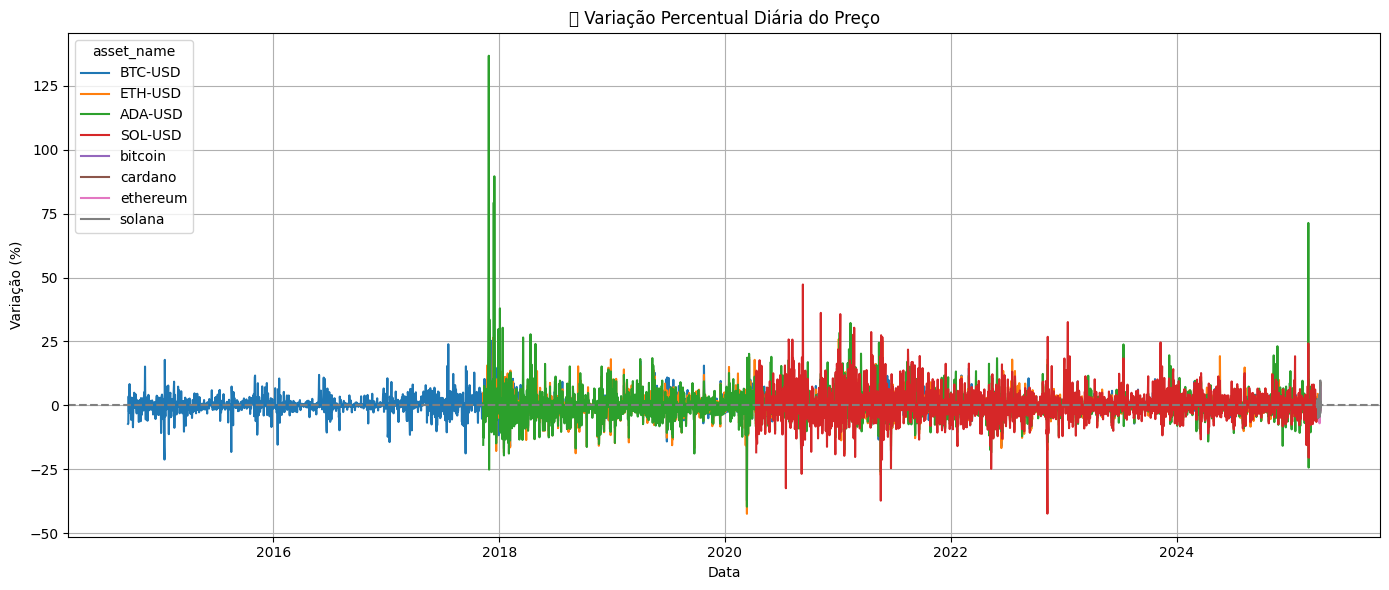

In [0]:
# Cálculo da variação percentual diária
df_var = df_price.copy()
df_var["pct_change"] = df_var.groupby("asset_name")["price_usd"].pct_change() * 100

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_var.dropna(), x="timestamp", y="pct_change", hue="asset_name")
plt.title("📊 Variação Percentual Diária do Preço")
plt.xlabel("Data")
plt.ylabel("Variação (%)")
plt.axhline(0, linestyle="--", color="gray")
plt.grid(True)
plt.tight_layout()
plt.show()

# ⏰ 3. Distribuição de Preço por Hora (Intradiário)

/root/.ipykernel/1146/command-6057980840509043-519975895:12: UserWarning: Glyph 128339 (\N{CLOCK FACE FOUR OCLOCK}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128339 (\N{CLOCK FACE FOUR OCLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


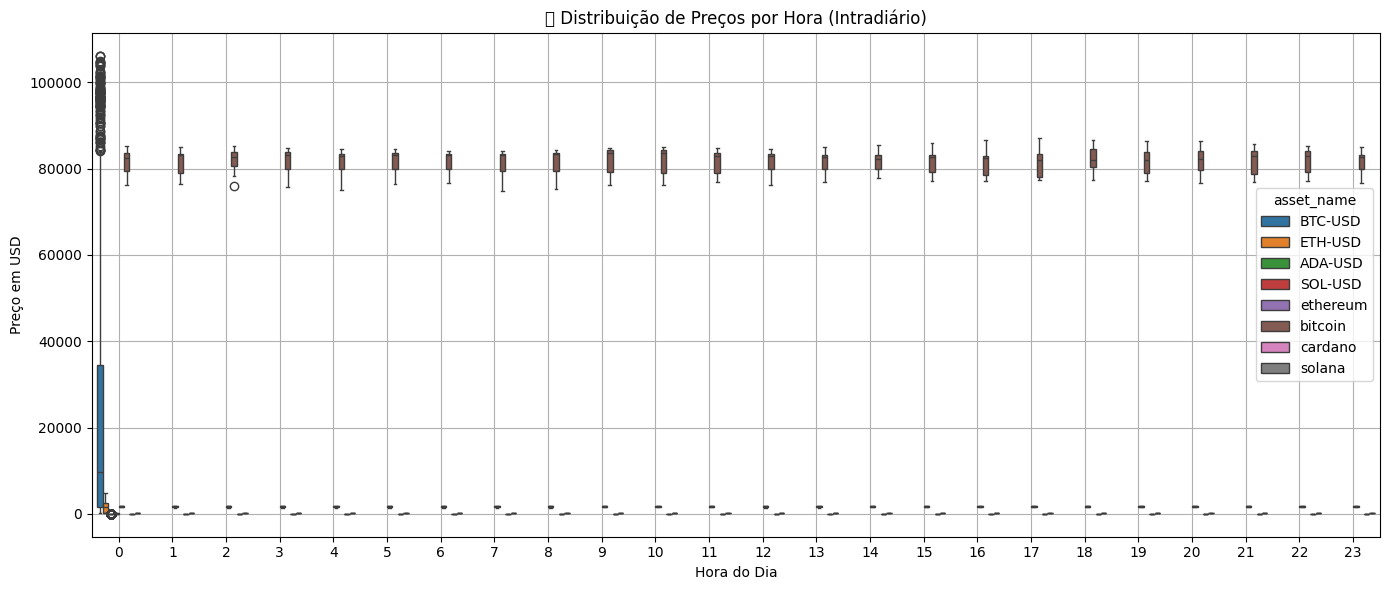

In [0]:
# Extrair hora
df_hourly = df_price.copy()
df_hourly["hour"] = df_hourly["timestamp"].dt.hour

# Plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_hourly, x="hour", y="price_usd", hue="asset_name")
plt.title("🕓 Distribuição de Preços por Hora (Intradiário)")
plt.xlabel("Hora do Dia")
plt.ylabel("Preço em USD")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 📌 Ranking de Valorização no Período

/root/.ipykernel/1146/command-6057980840509044-3533395878:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_rank, x="valorizacao_pct", y="asset_name", palette="viridis")
/root/.ipykernel/1146/command-6057980840509044-3533395878:18: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


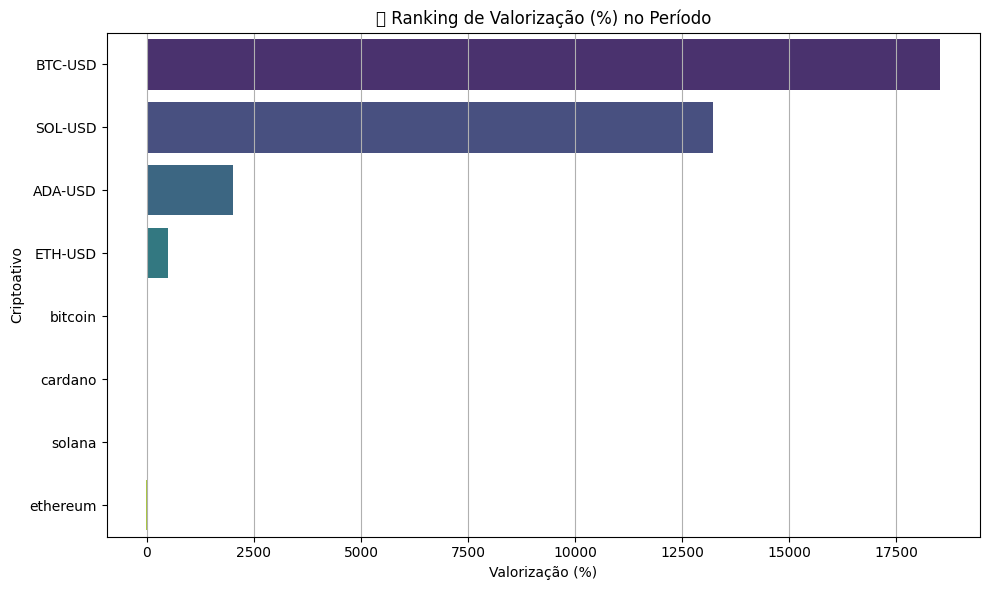

In [0]:
# Agrupamento por ativo - preço inicial e final
df_rank = df_price.groupby("asset_name").agg(
    inicio=("price_usd", lambda x: x.iloc[0]),
    fim=("price_usd", lambda x: x.iloc[-1])
).reset_index()

# Cálculo da valorização
df_rank["valorizacao_pct"] = ((df_rank["fim"] - df_rank["inicio"]) / df_rank["inicio"]) * 100
df_rank = df_rank.sort_values(by="valorizacao_pct", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_rank, x="valorizacao_pct", y="asset_name", palette="viridis")
plt.title("📌 Ranking de Valorização (%) no Período")
plt.xlabel("Valorização (%)")
plt.ylabel("Criptoativo")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
